## Grape Derivation

The goal of the GRAPE algorithm is to calculate the evolution and gradients with respect to control fields of unitary evolution.  

We assume piecewise constant evolution.  

The system evolution has the following components:
A "drift" Hamiltonian $H_0$ which is constant and beyond the control of the experimentalist, and a set of control Hamiltonians ${H_k}$ which can be controlled in small (time = $dt$) piecewise steps, with amplitudes $u_{kj}$ for each timestep $j$. 

First we will show how to evolve the state forward:

Let 
$$H_j = H_0 + \sum_k u_{kj} H_k $$
and
$$U_j = e^{-i H_j dt} $$
then 
$$U(T) = U_n U_{n-1} .. U_{j+1} U_j .. U_1  = \prod_{j=n \rightarrow 1} U_j $$

We would like to realize a target unitary $U_t$ and an infidelity metric

$$ \Phi = 1-|\left<U_t|U(T)\right>|^2 =1- |Tr ( U_t^{\dagger} U(T))|^2 $$

which is a measure of the distance between the two operators.  With this metric defined one can use a Nelder-Mead or other non-gradient based optimization techniques.  However, one can typically optimize much faster by making use of gradients especially if they are computationally cheap to compute symbolically (rather than approximating using finite differences).  The heart of the GRAPE method is the realization that this is very easy to do using a back-propagation procedure similar to neural networks (after it was uncool, and before it became cool again).  

Let's calculate the gradient with respect to a particular control parameter $u_{kj}$.

$$\frac{\partial \Phi}{\partial u_{kj}} = \frac{\partial}{\partial u_{kj}} \left(Tr( U_t^{\dagger} U_n U_{n-1} ..U_{j+1} U_j .. U_1))Tr( U_t^{\dagger} U_n U_{n-1} ..U_{j+1} U_j .. U_1))^{\dagger} \right)$$

Note that all of the matrices are constant with respect to $u_{kj}$ except for $U_j$.  The derivative $\frac{\partial}{\partial u_{kj}} U_j \approx - i dt H_k U_j$, which approximates $H_k$ as commuting with $U_j$, which is ok for small enough timesteps, but might not be always adequate.  In this derivation and code we will assume that it is valid, though I believe there are some other derivations/implementations that account for these corrections to higher order. 

Using this we can write the derivative of the infidelity as

$$\frac{\partial \Phi}{\partial u_{kj}} = -Tr(-i dt P_j^\dagger H_k X_j) Tr(X_j^\dagger P_j) - Tr(P_j^\dagger X_j) Tr(i dt H_k X_j^\dagger P_j) $$

where $X_j=U_j U_{j-1} .. U_1$ and $P_j = U_{j+1}^\dagger U_{j+2}^\dagger .. U_n^\dagger U_t$.  The first term and second term are complex conjugates so this can be conveniently written as

$$\frac{\partial \Phi}{\partial u_{kj}} = 2 Re\left(i dt Tr( P_j^\dagger H_k X_j) Tr(X_j^\dagger P_j)\right) $$

Now there is only the matter of efficiently calculating these derivatives.  The dimension of the Hilbert space might be quite large, and there may be many timesteps so one does not want to recalculate any matrices or do any extra multiplies.  The nice structure of $X_j$ and $P_j$ makes it very easy to calculate this efficiently.  The basic algorithm is as follows.

First calculate $X_n=U(T)$ by evolving the system forward in time as above.  Let $P_n = I$ the identity.  Starting at the last timestep backpropagate to get the gradient for each $u_{kj}$ by noting that $X_{j-1} = U_j^\dagger X_{j}$ and similarly that $P_{j-1} = U_j^\dagger P_j$. Therefore the cost of calculating the gradient is essentially the same as computing the forward time evolution.  One can save a bit of time at the cost of a lot of memory by caching the $U_j$'s on the forward pass.  

With the gradients in hand one can use their favorite gradient descent algorithm, it appears that L-BFGS is a good choice for this type of problem.  

## Forbidden State Cost function

A challenge in simulating even modest sized systems is leakage into other subspaces.  For example, when operating a transmon qubit, the finite anharmonicity means that other states may participate.  In the case that this is not desired we derive a cost function which will suppress occupation of such _forbidden_ states. 

Let $\vert s\rangle$ be _selected_  states, and $\vert f\rangle$ be _forbidden_ states (together forming an orthonormal basis for the space).  We define our cost function as

$$\Phi = \sum_{f,s} \int_0^{T} dt {\left|\langle f \vert U(t) \vert s  \rangle \right|^2} $$

This cost function penalizes any probability to transfer from a _selected_ initial state to any _forbidden_ state.  The integral makes it so that it penalizes any intermediate occupation as well as final occupation (which would have been covered by the trace distance).  We will first show how to calculate this cost as part of the forward evolution, and then show that the gradient can be efficiently calculated, with a single backwards pass along with the trace distance cost function.  



# Grape class

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%config InlineBackend.figure_format = "retina" # you can thank Ge for this.
import numpy as np
#from tqdm import tqdm
import scipy
from scipy.optimize import minimize
from numpy.linalg import eig
from IPython import display
import time
import numpy as np


try:
    import pycuda.autoinit
    import pycuda.gpuarray as gpuarray
    import pycuda.driver as drv

    import skcuda.linalg as culinalg
    import skcuda.misc as cumisc
    culinalg.init()

    to_gpu=gpuarray.to_gpu

    def gpu_free(*gpu_vs):
        for gpu_v in gpu_vs:
            gpu_v.gpudata.free()
            
    def gpu_get(gpu_v):
        return gpu_v.get()

    print "GPU Memory Used/total: %.2f/%.2f GB" % (drv.mem_get_info()[0]/1e9,drv.mem_get_info()[1]/1e9)
    GPU_Available=True
except Exception, e:
    print e
    print "Could not load GPU libraries"
    GPU_Available=False
    
    def gpu_free(*gpu_vs):
        pass
    
    def gpu_get(gpu_v):
        return gpu_v


Can't load cusolver --ds
GPU Memory Used/total: 0.35/8.51 GB


In [ ]:
m_size=100
a= np.asarray(np.random.rand(m_size,m_size) + 1j * np.random.rand(m_size,m_size), np.complex64)
b= np.asarray(np.random.rand(m_size,m_size) + 1j * np.random.rand(m_size,m_size), np.complex64)
ga=to_gpu(a)
gb=to_gpu(b)
gc=cudot(ga,gb)

gd=gc/5.

ge=ga+gb

np.allclose(gpu_get(ge),a+b)

In [6]:
complexX=np.complex64   
class GPUGrape:
    def __init__(self,H0,ops,dt,T,alpha=0.,dwdt_alpha=0., d2wdt2_alpha=0., fs_alpha =0., dc_alpha=0., Ut=None, selected_states=None, forbidden_states=None, use_gpu=True):
        self.use_gpu=True
        self.setup_gpu()
        self.H0=H0.astype(complexX)
        self.ops=ops       
        self.gops= [ to_gpu(op.astype(complexX)) for op in self.ops ]
        
        self.dt=dt
        self.T = T
        self.t = np.arange(0,T,dt)
        self.timesteps = len(self.t)
        self.I = np.identity(len(H0),dtype=complexX)
        self.gI = to_gpu(self.I)
        self.Ut = Ut.astype(complexX)
        self.alpha = alpha
        self.dwdt_alpha = dwdt_alpha
        self.d2wdt2_alpha = d2wdt2_alpha
        self.fs_alpha = fs_alpha
        self.dc_alpha = dc_alpha
        self.selected_states=selected_states
        self.forbidden_states=forbidden_states

        self.D = (-(0+1j) * dt * H0).astype(complexX)
        self.gD = to_gpu(self.D)
        self.Hks= np.asarray([dt*(0-1j)*op.astype(complexX) for op in self.ops], dtype=complexX).swapaxes(0,-1)
        self.gHks = [to_gpu(dt*(0-1j)*op.astype(complexX)) for op in self.ops]
        #print "ghks: %d" % self.gHks.nbytes 
        self.div = max(int(2*np.log2(np.max(np.abs(self.D)))),0)
        self.reset_convergence()

    def setup_gpu(self):
        
        la_funcs=["dot","conj","transpose","diag","hermitian"]
        
        try:
            self.gpu_available= GPU_Available
        except:
            self.gpu_available= False
        
        if self.gpu_available and self.use_gpu:
            for f in la_funcs: setattr(self, f, getattr(culinalg,f))
            self.to_gpu=gpuarray.to_gpu
            self.zeros=cumisc.zeros
            
        else:
            for f in la_funcs: setattr(self, f, getattr(np,f))
            self.to_gpu=np.copy
            self.zeros=np.zeros

            
            
            
                
            
        
#    def get_Hj(self,uj):
#        return np.reshape(np.dot(self.Hks,uj).swapaxes(0,-1),(self.Hks.shape[0],self.Hks.shape[1]))

    def get_Hj(self,uj):
        gHj=self.zeros(self.H0.shape,dtype=complexX)
        for ii, uji in enumerate(uj):
            gHj = gHj + self.gHks[ii] * complexX(uji)
        return gHj
 
    def Mcos(self,gU1,gU2):
        if self.selected_states is not None:
            return np.sum(gpu_get(self.diag(self.dot(self.hermitian(gU1),gU2)))[self.selected_states])/len(self.selected_states)
        else:
            return self.trace(self.dot(self.hermitian(gU1),gU2))/len(gU1)

        
    def approx_expm(self,gM,terms=6, div=0):
        gU=to_gpu(np.identity(len(gM),dtype=gM.dtype))
        gMt=to_gpu(np.identity(len(gM),dtype=gM.dtype))
        iif=1.0
        
        for ii in xrange(1,terms):
            iif*=ii
            gMt=self.dot(gMt,gM)
            gU=gU+gMt/complexX(((2.**float(ii*div))*iif))
        
        for ii in xrange(div):
            gU=self.dot(gU,gU)
        
        gpu_free(gMt)
        return gU

        
    def evolve(self,uks,psi_0=None,show_plots = False):
        fs_penalty = self.forbidden_states is not None and self.selected_states is not None and self.fs_alpha>0
        self.uks=uks
        uksT=uks.T
        psis=[]
        self.gUf=to_gpu(self.I)
        self.fs_cost = 0.
        if psi_0 is not None:
            gpsi_0 = to_gpu(psi_0.reshape(len(psi_0),1))
        #print drv.mem_get_info()
        for jj in xrange(self.timesteps):
            gHj = self.gD+self.get_Hj(uksT[jj].astype(complexX))                  #Hamiltonian for this time step
            gUj = self.approx_expm(gHj,div=self.div)
            if fs_penalty:
                M = (gpu_get(self.gUf)[self.forbidden_states][:,self.selected_states])
                self.fs_cost += self.fs_alpha*np.sum(M.real**2+M.imag**2)/(len(self.selected_states)*len(self.forbidden_states))
            #print self.gUf.dtype, gUj.dtype, gHj.dtype, self.D.dtype, self.Hks.dtype
            self.gUf = self.dot(gUj,self.gUf)
            if psi_0 is not None: 
                psis.append(np.reshape(gpu_get(self.dot(self.gUf,gpsi_0)),(len(psi_0))))
        self.psis = np.transpose(psis)
        if show_plots: self.show_plots()
        self.Uf=gpu_get(self.gUf)
        gpu_free(gpsi_0,gHj,gUj)
        #print drv.mem_get_info()
        return self.Uf, self.psis
    
    def cost(self,Ut,uks):
        gUt=to_gpu(Ut)
        self.cost_labels=['Mcos','dc','|uks|^2','dwdt','fs']
        self.costs = [(1-abs(self.Mcos(self.gUf,gUt))**2),
                      self.dc_alpha*np.sum(np.sum(uks,axis=-1)**2),
                      self.alpha*self.dt*np.sum(uks**2),
                      self.dwdt_alpha*self.dwdt_cost(uks),
                      self.fs_cost]
        
        gpu_free(gUt)
        self.cost_labels.append('total')
        self.costs.append(np.sum(self.costs))
        
        return self.costs[-1]

    def dwdt_cost (self,uks):
        return np.sum(np.diff(uks,axis=-1)**2)

    def dwdt_grad (self,uks):
        return -2.*np.hstack((np.array([uks[:,1]-uks[:,0]]).T,np.diff(uks,n=2,axis=-1),np.array([uks[:,-2]-uks[:,-1]]).T))

    
    def grads(self,Ut,uks):
        fs_penalty = self.forbidden_states is not None and self.selected_states is not None and self.fs_alpha>0
        dCduk=np.zeros(uks.shape)
        fs_g =np.zeros(uks.shape)
        uksT=uks.T
        gXj = to_gpu(self.Uf)
        gPj = to_gpu(Ut)
        gPj2 = to_gpu(np.identity(Ut.shape[0]))
        for jj in xrange(self.timesteps-1,-1,-1):
            for kk in range(len(self.ops)):
                dCduk[kk,jj]=2*np.real((0+1j)*dt*self.Mcos(gPj,self.dot(self.gops[kk],gXj))*self.Mcos(gXj,gPj))
                if fs_penalty:
                    fs_g[kk,jj] = np.sum(2.*gpu_get(self.dot(Pj2,self.dot(self.gops[kk],gXj)))[self.forbidden_states][:,self.selected_states])
            gHj_dag = -(self.gD+self.get_Hj(uksT[jj]))   # Construct the Hj_dag
            gUj_dag = self.approx_expm(gHj_dag,div=self.div)          # approximate Uj_dag
            gXj = self.dot(gUj_dag,gXj)                     # Take Uj away from Xj
            gPj = self.dot(gUj_dag,gPj)                     # Put Uj_dag onto Pj
            if fs_penalty: gPj2 = self.dot(gPj2,self.hermitian(gUj_dag))+self.gI
        if fs_penalty: 
            fs_g *= self.fs_alpha/(len(self.selected_states)*len(self.forbidden_states))
        
        self.grad_list=[dCduk,
                        2*self.dc_alpha*np.tile(np.sum(uks,axis=-1),(uks.shape[1],1)).T,
                        2*self.alpha*self.dt*uks, 
                        self.dwdt_alpha*self.dwdt_grad(uks),
                        fs_g]
        
        self.grad_list.append(np.sum(self.grad_list,axis=0))
        return self.grad_list[-1]


    def show_CM(self,M):
        plt.figure(figsize=(15,7))
        plt.subplot(121)
        plt.imshow(M.real,interpolation='none')
        plt.clim(-1,1)
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(M.imag,interpolation='none')
        plt.clim(-1,1)
        plt.colorbar()

    def show_psis(self):
        plt.figure(figsize=(15,7))
        plt.subplot(131,title='Real')
        for psi in self.psis:
            plt.plot(self.t,psi.real)
        plt.ylim(-1,1)
        plt.subplot(132,title='Imag')
        for psi in self.psis:
            plt.plot(self.t,self.psi.imag)
        plt.ylim(-1,1)
        plt.subplot(133,title='Probability')
        for psi in self.psis:
            plt.plot(self.t,psi*psi.conj())
        plt.ylim(0,1)

    def show_plots(self):
        plt.figure(figsize=(15,15))
        plt.subplot(411,title='Control fields')
        for uk in self.uks:
            plt.plot(self.t,uk)  
        plt.subplot(412,title='Probability')
        for psi in self.psis[:]:
            plt.plot(self.t,psi*psi.conj())
        plt.ylim(0,1)   
        plt.subplot(413,title='Real')
        for psi in self.psis[:]:
            plt.plot(self.t,psi.real)
        plt.ylim(-1,1)
        plt.subplot(414,title='Imag')
        for psi in self.psis[:]:
            plt.plot(self.t,psi.imag)
        plt.ylim(-1,1)

    def show_convergence_plots(self):
        gs=gridspec.GridSpec(3,2)
        plt.subplot(gs[0,0],title='Costs')
        for cost_label, cost in zip(self.cost_labels,np.transpose(self.cost_convergence)):
            plt.plot(np.array(cost),label=cost_label)
        plt.title('Error = %f: calls/s = %f runtime = %f s' % (self.last_cost, len(self.cost_convergence)/(time.time()-self.start_time),(time.time()-self.start_time)))
        plt.ylabel('Error')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc=3)
        
        plt.subplot(gs[0,1],title='Grads')
        for cost_label, g in zip(self.cost_labels,np.transpose(self.grad_convergence)):
            plt.plot(np.array(g),label=cost_label)
        plt.ylabel('|grad|')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc=3)
        
        plt.subplot(gs[1,:],title='Control fields')
        for uk in self.uks:
            plt.plot(self.t,uk)
            
#         plt.subplot(gs[2,:],title='Spectrogram')
#         Pxx, freqs, bins, im = plt.specgram(self.uks[0], NFFT=64, Fs=1./self.dt, noverlap=32)
#         plt.ylim(0,1./self.dt)
            
        plt.subplot(gs[2,:],title='Probability')
        #print self.psis.shape
        for psi in self.psis[:]:
            plt.plot(self.t,np.abs(psi)**2)

        fig = plt.gcf()
        fig.set_size_inches(15, 10)

    
    def reset_convergence(self):
        self.cost_convergence=[]
        self.grad_convergence=[]
        self.start_time=time.time()
        self.last_t=self.start_time
        
    def update_convergence(self,show_plot=True):
        self.cost_convergence.append(self.costs)
        self.grad_convergence.append([np.sum(g**2) for g in self.grad_list])
        if show_plot and (((time.time()-self.last_t) > 3) or (self.last_t == self.start_time)):
            self.show_convergence_plots()
            self.last_t=time.time()
            display.clear_output(wait=True)
            display.display(plt.gcf())


    def randn_uks(self,amp=1.0,lp=None):
        if lp is None: lp=self.timesteps/10.
        uks=[]
        for op in self.ops:
            v=np.convolve(np.random.randn(self.timesteps),np.ones(lp),mode='same')
            uks.append(amp*v/np.sqrt(np.dot(v,v)))
        return np.array(uks)

    def opt_fun(self,uks):
        self.evolve(uks,psi_0=self.psi_0)
        self.last_cost  = self.cost(self.Ut,uks)
        grads = self.grads(self.Ut,uks)
        return self.last_cost,grads

    def minimize_opt_fun(self,x):
        cost,grads=self.opt_fun(np.reshape(x,(len(self.ops),len(x)/len(self.ops))))
        self.update_convergence()
        return cost,np.reshape(grads,(grads.shape[0]*grads.shape[1]))
    
    def optimize(self, x0, Ut=None, psi_0=None,method='Nelder-Mead',jac = False, options=None,show_plots=False):
        self.psi_0=psi_0
        self.reset_convergence()
        if show_plots: plt.figure()
        if Ut is not None: self.Ut=Ut
        try:
        
            res = minimize(self.minimize_opt_fun,x0,method=method,jac=jac,options=options)
            display.clear_output()
            print res
            uks=np.reshape(res['x'],(len(self.ops),len(res['x'])/len(self.ops)))
            return res, uks
        except KeyboardInterrupt:
            display.clear_output()
            print "Aborted at iteration %d" % (len(self.cost_convergence))



# Examples

## Fast pulses in presence of small anharmonicity (like DRAG)

In [ ]:
# System parameters
ms  = 2**8
alpha = -0.2
fq = 4.
ens = 2*np.pi*(fq*np.arange(ms)+alpha*(np.arange(ms)-1)*(np.arange(ms))/2.)
H0  = np.diag(ens)
x   = np.diag(np.sqrt(np.arange(1,ms)),1)+np.diag(np.sqrt(np.arange(1,ms)),-1)
y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,ms)),1)-np.diag(np.sqrt(np.arange(1,ms)),-1))
dt  = 1./fq/10.
total_time=5

# define target Unitary evolution (regular H0 w/ X gate on 1st 2 levels)
Ut = scipy.linalg.expm((0-1j)*total_time*H0)
Ut[0,1] = 1
Ut[1,0] = 1
Ut[0,0] = 0 
Ut[1,1] = 0

# initial state for showing evolution
psi_0 = np.zeros(len(H0),dtype=complexX)/np.sqrt(len(H0))
psi_0[0] = 1.

# instantiate grape class
g=GPUGrape(H0,[x,y],dt,total_time,Ut=Ut,
        dc_alpha=1e-6,alpha=5e-4,dwdt_alpha=1e-2,fs_alpha=0*1e-3,
       selected_states=[0,1],forbidden_states=range(2,ms),use_gpu=False)

# make initial guess of control fields 
sigma=50.
a=0.05
t0=g.t[-1]/2.

# gaussian pulse at 0-1 frequency
#uks0=np.array([np.ones(len(g.t))*0.001,a*np.exp(-(g.t-t0)**2/(2.*sigma**2))*np.sin((ens[1]-ens[0])*g.t)], dtype=complexX)
# or just random normal distributed/low passed control fields
uks0=g.randn_uks(amp=10,lp=3)
#uks0=np.zeros(uks0.shape)
#Print Initial guess
Uf,psis=g.evolve(uks0,psi_0,show_plots=False)
print "done"
#g.show_CM(Uf)
#plt.clim(-1,1)
#print "|<U(T)|U(T)>| = %f " % abs(g.Mcos(g.Uf,g.Uf))
#print "|<U(T)|U_t>| = %f " % abs(g.Mcos(g.Uf,g.Ut))
#print np.max(H0)

done


Aborted at iteration 22


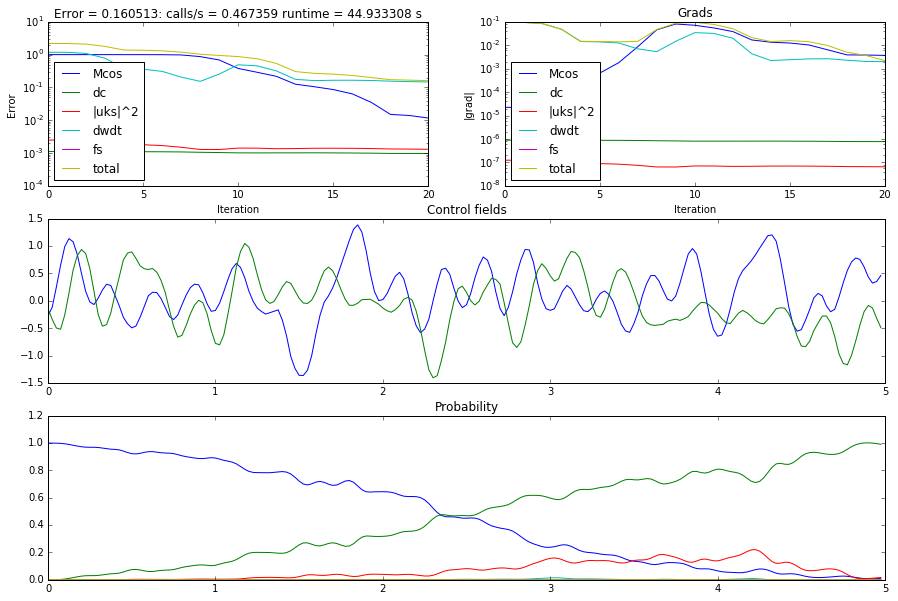

In [ ]:
# Optimize pulse based on initial guess
res=g.optimize(uks0, psi_0=psi_0,method='BFGS',jac = True, options={'maxiter' :500,'ftol' : 1e-15,'gtol' : 1e-15, 'eps':1e-15},show_plots=True)
#g.show_CM(g.Ut)
#uks0=res['x']

In [ ]:
print "|<U(T)|U(T)>| = %f\t|<U(T)|U_t>| = %f " % (abs(np.dot(g.Uf.T.conj(),g.Uf).trace())/len(g.Uf),abs(g.Mcos(g.Uf,g.Ut)))

## Multimode

In [ ]:
# qubit
# System parameters
qubit_levels = 4
alpha = -0.2
fq = 4.
ens = 2*np.pi*(fq*np.arange(qubit_levels)+alpha*(np.arange(qubit_levels)-1)*(np.arange(qubit_levels))/2.)
Hq  = np.diag(ens)
qx   = np.diag(np.sqrt(np.arange(1,qubit_levels)),1)+np.diag(np.sqrt(np.arange(1,qubit_levels)),-1)
qy   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_levels)),1)-np.diag(np.sqrt(np.arange(1,qubit_levels)),-1))
qz   = np.diag(ens-ens[0])/(2*np.pi*fq)
qI   = np.identity(qubit_levels)
dt  = 0.005
total_time=5    

# Multimode cavities
r_levels = 3
f1 = 5.0
f2 = 5.1
Hr1 = np.diag(2*np.pi*f1*np.arange(r_levels))
Hr2 = np.diag(2*np.pi*f2*np.arange(r_levels))
rx   = np.diag(np.sqrt(np.arange(1,r_levels)),1)+np.diag(np.sqrt(np.arange(1,r_levels)),-1)
rI   = np.identity(r_levels)
rn   = np.diag(np.arange(r_levels))

# Coupling
g1 = 0.075
g2 = 0.075

# Make basis states in direct product space
def psi_n (n,d):
    psin=np.zeros(d)
    psin[n]=1.
    return psin
    
def basis_state(nq,nr1,nr2):
    return np.kron(psi_n(nq,qubit_levels),np.kron(psi_n(nr1,r_levels),psi_n(nr1,r_levels)))

def dressed_level(ev,psi):
    return np.argmax(np.abs(np.dot(ev,psi)))

def chopv(v,tol=.01):
    v[np.abs(v) < tol]=0
    return v

# Make operators in direct product space
H0 = np.kron(Hq,np.kron(rI,rI)) + np.kron (qI,np.kron(Hr1,rI)) + np.kron(qI,np.kron(rI,Hr2)) + \
     g1*np.kron(qx,np.kron(rx,rI))+g2*np.kron(qx,np.kron(rI,rx))

Hqx = np.kron(qx,np.kron(rI,rI))
Hqy = np.kron(qy,np.kron(rI,rI))
Hqz = np.kron(qy,np.kron(rI,rI))
    
# setup simulation parameters
dt  = 1./(2*np.pi*max((fq,f1,f2)))/10.
total_time=5

en,ev = eig(H0)
ev = np.transpose(np.array(ev))[np.argsort(en)]
en = np.sort(en)


# Figure out logical subspace and leakage space
forbidden_states=[]
selected_states=[]
for ii in range(qubit_levels):
    for jj in range(r_levels):
        for kk in range(r_levels):
            state=dressed_level(ev,basis_state(ii,jj,kk))
            if jj!=r_levels-1 and kk != r_levels-1 and ii != qubit_levels-1:
                selected_states.append(state)
            else:
                forbidden_states.append(state)

# # define target Unitary evolution (regular H0 w/ X gate on 1st 2 levels)
UD = np.transpose([ev[dressed_level(ev,psi_n(ii, len(ev)))] for ii in xrange (len(ev))]) #  |\tilde{j}>=Ud |j>
D  = np.dot(np.dot(ev,H0),ev.conj().T)
sx = np.identity(qubit_levels)
sx[0,0] = 0
sx[1,1] = 0
sx[0,1] = 1
sx[1,0] = 1
Hsx=np.kron(sx,np.kron(rI,rI))

Ut = np.dot(np.dot(UD,np.dot(Hsx,UD.conj().T)),scipy.linalg.expm((0-1j)*total_time*(D)))
 
# initial state for showing evolution
psi_0 = np.zeros(len(H0),dtype=complexX)
psi_0[0] = 1.

# instantiate grape class
g=GPUGrape(D,[Hqx,Hqy],dt,total_time,Ut=Ut,
        dc_alpha=1e-8,alpha=5e-6,dwdt_alpha=1e-8,fs_alpha=0*1e-3,
        selected_states=selected_states,forbidden_states=forbidden_states)

# or just random normal distributed/low passed control fields
uks0=g.randn_uks(amp=10,lp=3)
#Print Initial guess
Uf,psis=g.evolve(uks0,psi_0,show_plots=False)
#print "|<U(T)|U(T)>| = %f " % abs(g.Mcos(g.Uf,g.Uf))
#print "|<U(T)|U_t>| = %f " % abs(g.Mcos(g.Uf,g.Ut))
print len(D)
#print len(g.t)

In [ ]:
# Optimize pulse based on initial guess
res=g.optimize(uks0, Ut=None, psi_0=psi_0,method='L-BFGS-B',jac = True, options={'maxiter' : 1000,'ftol' : 1e-7},show_plots=True)
g.show_CM(g.Ut)

In [ ]:
print "|<U(T)|U_t>| = %f " % abs(g.Mcos(g.Uf,g.Ut))

## Operations to try

### Single Qubit
* Transmon Rotations (vs. level #)

### Multi-Qubit
* CZ
* CNOT
* Toffoli
* QFT

### Qubit - Cavity manipulation
* Qubit - cavity swap
* Number selective (2)pi pulse
* Number parity operator
* Create Cat state
* Create Cat code state
* Cat code single qubit rotation

### Multimode
* Qubit g-e rotations
* Qubit e-f rotations
* Qubit g-e mode swap
* Qubit mode CNOT
* Qubit mode CZ
* Mode-mode CNOT
* Mode-mode CZ
* Mode Parity
* Mode correlators


In [ ]:
# operators

sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])
sI = np.identity(2)

def destroy(n):
    return np.diag(np.sqrt(np.arange(1,n)),1)

def transmon(w,alpha,n):
    return wq*np.arange(n)+alpha*(np.arange(n)-1)*(np.arange(n))/2.
    
def qft(n):
    a = np.arange(2**n)
    x, y = np.meshgrid(a, a)
    return (1.0 / np.sqrt(2**n))*np.exp((2.0j * np.pi / 2**n) * (x * y))

def multi_kron(ops):
    ans=ops[0]
    for op in ops[1:]:
        ans=np.kron(ans,op)
    return ans


In [ ]:
multi_kron((np.array([0,1]),np.array([1,0])))

In [ ]:
#Multi qubit unitaries

def get_CZ(q1,q2,n):
    []
    scipy.linalg.expm(-np.outer())